# IA Deep Learning : Handwritten number recognition

- The aim will be to build a neural network that recognises handwritten digits. We will use the classic dataset [MNIST](http://yann.lecun.com/exdb/mnist/).

- We will consider a "dense" architecture (no Convolution here). Images will therefore be considered as vectors of size 28*28.

## Loading and reading data
- library needed for the rest of the project

In [1]:
import torch
import torchmetrics
from torch.utils.data import Dataset
from torch.utils.data.dataloader import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.transforms import Lambda
from torchvision.transforms import Compose
import matplotlib.pyplot as plt
from torch import autograd as autograd
from torch.autograd import grad
import torch.nn as nn
import torch.optim as optim

In [2]:
# Create a composition of the two transformations to be applied to the images
Compose_transform = Compose([
    ToTensor(),
    Lambda(lambda x: torch.flatten(x))
])

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform = Compose_transform
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform = Compose_transform
)

In [3]:
# Create `DataLoaders` for training and test datasets.
# 64 images per batch
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [4]:
for X, y in train_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    
    # We print some values to check the data    
    print("Exemple of X value : ", X[0])
    print("Exemple of y value : ", y[0])
    
    break

Shape of X [N, C, H, W]:  torch.Size([64, 784])
Shape of y:  torch.Size([64]) torch.int64
Exemple of X value :  tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0196, 0.2314, 0.6431, 0.4039, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4314, 0.9843, 0.9843, 0.9843,
        

## Automatic differentiation with Autograd

- To calculate gradients and implement gradient descent, PyTorch has the `torch.autograd` automatic differentiation engine, which automatically calculates the gradient for any computational graph.
- Consider the function : 
$$ (w,b) \in \mathbb{R}^5  \times \mathbb R \mapsto   \sum_{j=0}^4  j  \cdot\left(\sin (w_j) +b \right)^2 $$
- Using autograd, we will calculate the gradient of this function at the point w=0, b = 1.

In [5]:
# Define the function
def func(w, b):
    result = 0.0
    for j in range(5):
        result += j * (torch.sin(w[j]) + b)**2
    return result

# Define the value of w and b for the function
w = torch.zeros(5, requires_grad=True)
b = torch.tensor(1.0, requires_grad=True)

# Calculate the function output
output = func(w, b)

# Calculate the gradient
gradient = grad(output, (w, b))

# Print the gradient
print("Gradient par rapport à w : ", gradient[0])
print("Gradient par rapport à b : ", gradient[1])


Gradient par rapport à w :  tensor([0., 2., 4., 6., 8.])
Gradient par rapport à b :  tensor(20.)


- We can easily verify these results by calculating
- consider $f$ such that : $ f(w,b) = \left(\sin (w_j) +b \right)^2 $
$$\frac{\partial f}{\partial w_j} = \frac{\partial}{\partial w_j} \left(\sin (w_j) +b \right)^2 $$
$$ \frac{\partial f}{\partial w_j} = 2 \times \frac{\partial }{\partial w_j} (\sin (w_j) + b) \times (\sin(w_j) + b) $$
$$ \frac{\partial f}{\partial w_j} = 2 \times \cos (w_j) \times (\sin(w_j) + b) $$ 
with $ w_j = 0$ and $ b = 1$ we have:  
$$ \frac{\partial f}{\partial w_j} = 2 \times \cos (0) \times (\sin(0) + 1) = 2 \times 1 \times 1 = 2$$ 

then when we drift in relation to **b** : 
$$\frac{\partial f}{\partial b} = \frac{\partial}{\partial b} \left(\sin (w_j) +b \right)^2 $$
$$ \frac{\partial f}{\partial b} = 2 \times \frac{\partial }{\partial b} (\sin (w_j) + b) \times (\sin(w_j) + b) $$
$$ \frac{\partial f}{\partial b} = 2 \times \ 1 \times (\sin(w_j) + b) $$ 
with $ w_j = 0$ and $ b = 1$ we have:  
$$ \frac{\partial f}{\partial b} = 2 \times \ 1 \times (\sin(0) + 1) = 2 \times 1 \times 1 = 2$$ 


- Knowing that b is a one-dimensional tensor, all we have to do is multiply the result of the gradient with respect to b by this sum: $$ S = \sum_{j=0}^4  j = (n+1) \times \frac{u_o + u_n}{2} = (4+1) \times \frac{0+4}{2} = \frac{20}{2} = 10 $$
so we have the same result as with code $ b = S \times \frac{\partial f}{\partial b} = 10 \times 2 = 20 $


- For the gradient with respect to w, this is a 5-dimensional array, so each element is multiplied by the gradient, so for the first element we have $0 \times 2 = 0$, the 2nd element $1 \times 2 = 2$ etc ... 

## Network construction using the Sequential function

- **We want the network to read an image of 28 × 28 pixels** with intensities between 0 and 255, in the form of a vector of values between 0 and 1.
- We therefore create an input layer with 28 x 28 = 784 neurons. 
- We will also create two hidden layers containing 30 and 20 neurons respectively, and an output layer of 10 neurons representing the digits from 0 to 9. 
- The response of the network will be given by the number of the output neuron with the highest activation. In the three layers that are not the input, we use the logistic function (sigmoid): $L(x)=\frac{1}{1+e^{-x}}$.

In [6]:
# The logistic function
def logistic(x):
    return 1 / (1 + torch.exp(-x))

# Definition of the neural network with the sequential module
net1 = nn.Sequential(
    nn.Flatten(),                           # Input layer: Flatten the 28x28 image into a 784-value vector
    nn.Linear(784, 30),                     # First hidden layer with 30 neurons
    nn.Sigmoid(),                           # Activation function: Logistics function
    nn.Linear(30, 20),                      # Second hidden layer with 20 neurons
    nn.Sigmoid(),                           # Activation function: Logistics function
    nn.Linear(20, 10),                      # Output layer with 10 neurons for digits 0 to 9
    nn.Sigmoid()                            # Activation function: Logistics function
)

# Displaying network parameters
for name, param in net1.named_parameters():
    print(name, param.shape)

1.weight torch.Size([30, 784])
1.bias torch.Size([30])
3.weight torch.Size([20, 30])
3.bias torch.Size([20])
5.weight torch.Size([10, 20])
5.bias torch.Size([10])


In [7]:
# Number of classes for the classification
num_classes = 10  # For MINST dataset (digits 0 to 9)

# Function to compute the accuracy
def compute_accuracy(predictions, targets):
    # Use argmax to get the predicted labels
    predicted_labels = torch.argmax(predictions, dim=1)
    # Calculate the accuracy
    acc = torchmetrics.functional.accuracy(predicted_labels, targets, task='MULTICLASS', num_classes=num_classes)
    return acc

In [9]:
# Batch from the training sample
for images, labels in train_dataloader:
    predictions = net1(images)
    accuracy_batch = compute_accuracy(predictions, labels)
    print("Accuracy on one batch of the training sample :", accuracy_batch.item())
    break

Accuracy on one batch of the training sample : 0.171875


In [11]:
# Full learning sample
all_predictions_train = torch.cat([net1(images) for images, labels in train_dataloader])
all_labels_train = torch.cat([labels for images, labels in train_dataloader])
accuracy_train = compute_accuracy(all_predictions_train, all_labels_train)
print("Accuracy of the full learning sample :", accuracy_train.item())

Accuracy of the full learning sample : 0.09863333404064178


In [12]:
# Full test sample
all_predictions_test = torch.cat([net1(images) for images, labels in test_dataloader])
all_labels_test = torch.cat([labels for images, labels in test_dataloader])
accuracy_test = compute_accuracy(all_predictions_test, all_labels_test)
print("Accuracy of the full test sample :", accuracy_test.item())

Accuracy of the full test sample : 0.0957999974489212


Given that the network is not yet trained. We therefore have very poor accuracy 
> - on a batch of the training sample,
> - on the complete training sample,
> - on the complete test sample.

## Training

In [13]:
# Function to calculate the cross-entropy loss
def compute_cross_entropy(predictions, targets):
    # Compute the cross-entropy loss
    criterion = nn.CrossEntropyLoss()
    loss = criterion(predictions, targets)
    return loss

# Batch from the training sample
for images, labels in train_dataloader:
    predictions = net1(images)
    # Calculate the cross-entropy loss
    loss_batch = compute_cross_entropy(predictions, labels)
    print("Loss of cross-entropy for one batch of the training sample :", loss_batch.item())
    break

Loss of cross-entropy for one batch of the training sample : 2.310173749923706


To train the model, i.e. adjust the weights and biases, we will implement a stochastic gradient descent with the objective function being the loss of cross entropy (applied at the output of the network).

Here we choose to use the standard gradient descent optimizer, available in Pytorch via the function [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD).

Then we build a batch with the dataloader taking $m = 256$.   

In [14]:
# Initilization of the model
model = net1

# Define the optimizer hyperparameters
learning_rate = 0.01
momentum = 0.9

# Create the SGD optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

# Definition of the loss function
criterion = nn.CrossEntropyLoss()

# 256 images per batch
m = 256

# Initilisation of a list to store the data and labels of the batch
batch_images = []
batch_labels = []

# Build the batch by iterating over the DataLoader
for images, labels in train_dataloader:
    batch_images.append(images)
    batch_labels.append(labels)
    
    # Check if we have reached the desired batch size
    if len(batch_images) * images.shape[0] >= m:
        break

# Concatenate data and labels to form the batch
batch_images = torch.cat(batch_images, dim=0)[:m]
batch_labels = torch.cat(batch_labels, dim=0)[:m]

# Zero the gradients
optimizer.zero_grad()

# Forward propagation: calculate predictions
predictions = model(batch_images)

# Compute the cross-entropy loss
loss = criterion(predictions, batch_labels)

# Backpropagation: calculating gradients
loss.backward()

# Update weights and biases
optimizer.step()

# Print the loss after one iteration
print("Loss after one iteration :", loss.item())

Loss after one iteration : 2.3062686920166016


In [15]:
for input, target in train_dataloader: 
    optimizer.zero_grad()
    output = model(input)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()

# Now, let's explain the meaning of each command in this loop:
# optimizer.zero_grad(): This instruction is used to reset the gradients calculated during the previous backward pass. Gradients need to be cleared before calculating gradients for the new batch, otherwise the gradients will accumulate.
# output = model(input): This performs a forward pass through the model with the input data and gets the model's predictions.
# loss = criterion(output, target): This calculates the loss between the model's predictions (output) and the true labels (target) using the defined loss function, in this case, the cross-entropy loss function.
# loss.backward(): This instruction computes the gradients of the loss with respect to the model's parameters using automatic differentiation.
# optimizer.step(): This instruction updates the model's weights and biases by taking a step in the opposite direction of the gradients, according to the chosen optimizer.


In [16]:
# Redefine the DataLoader with a new batch size
batch_size = 10
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)

In [17]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X) + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.12
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.287270  [   10/60000]
loss: 2.330104  [ 1010/60000]
loss: 2.302551  [ 2010/60000]
loss: 2.100961  [ 3010/60000]
loss: 1.902298  [ 4010/60000]
loss: 1.944453  [ 5010/60000]
loss: 1.783159  [ 6010/60000]
loss: 1.804507  [ 7010/60000]
loss: 1.732282  [ 8010/60000]
loss: 1.750697  [ 9010/60000]
loss: 1.825851  [10010/60000]
loss: 1.742792  [11010/60000]
loss: 1.659687  [12010/60000]
loss: 1.639429  [13010/60000]
loss: 1.660804  [14010/60000]
loss: 1.843539  [15010/60000]
loss: 1.706730  [16010/60000]
loss: 1.654618  [17010/60000]
loss: 1.587069  [18010/60000]
loss: 1.611391  [19010/60000]
loss: 1.631912  [20010/60000]
loss: 1.692217  [21010/60000]
loss: 1.588870  [22010/60000]
loss: 1.669034  [23010/60000]
loss: 1.533099  [24010/60000]
loss: 1.782976  [25010/60000]
loss: 1.559480  [26010/60000]
loss: 1.806301  [27010/60000]
loss: 1.579204  [28010/60000]
loss: 1.549476  [29010/60000]
loss: 1.549604  [30010/60000]
loss: 1.592288  [31010/60000]


Finally, now that the network has been trained, we're going to use it to classify the test sample, then keep the examples that are misclassified and display them.

Misclassified samples 1:
Reel classe: 5, Predicted classe: 8


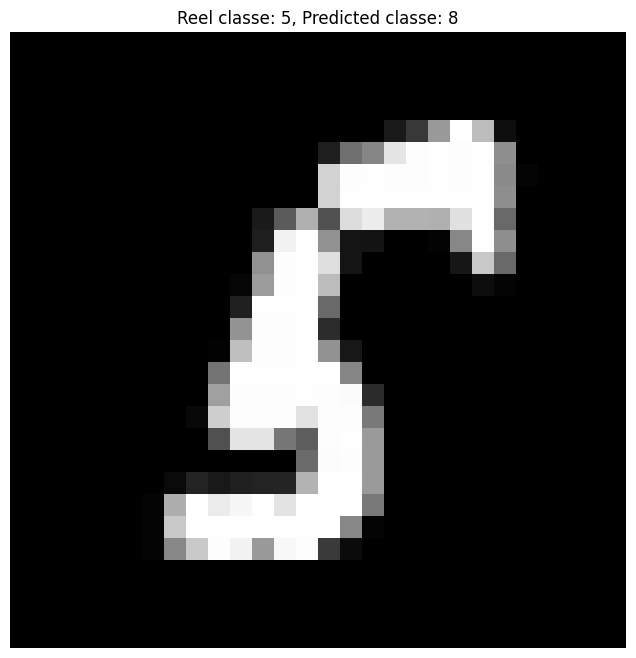

Misclassified samples 2:
Reel classe: 8, Predicted classe: 0


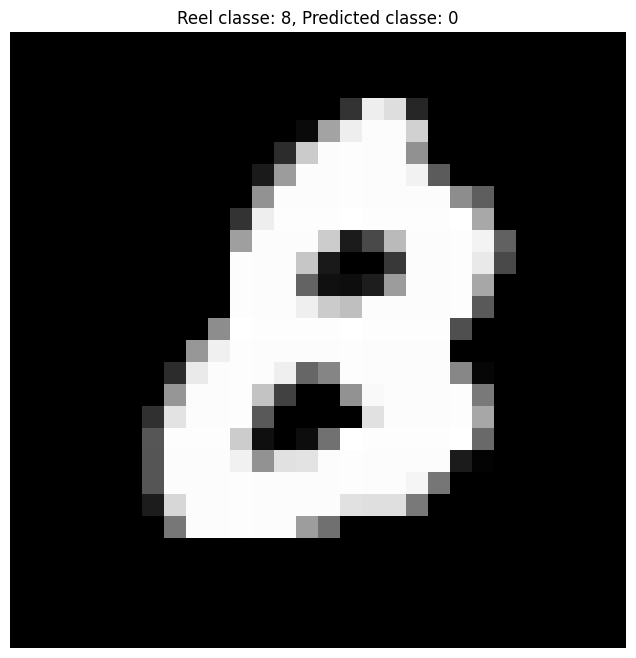

Misclassified samples 3:
Reel classe: 7, Predicted classe: 2


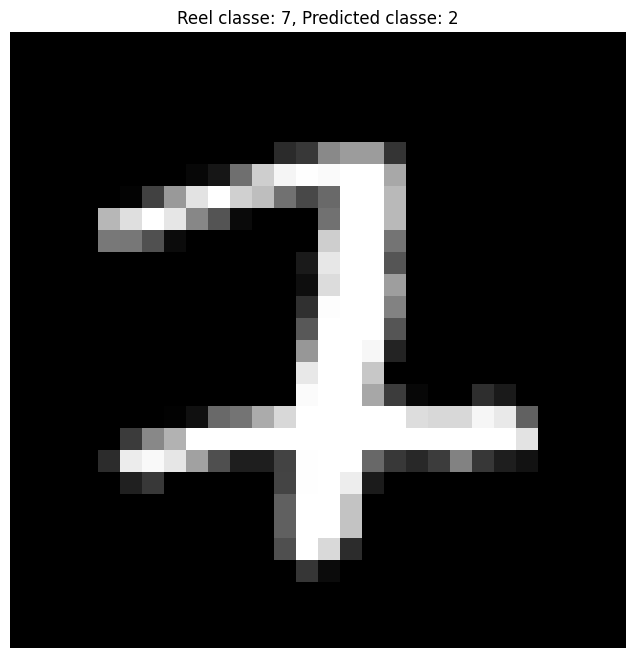

Misclassified samples 4:
Reel classe: 6, Predicted classe: 0


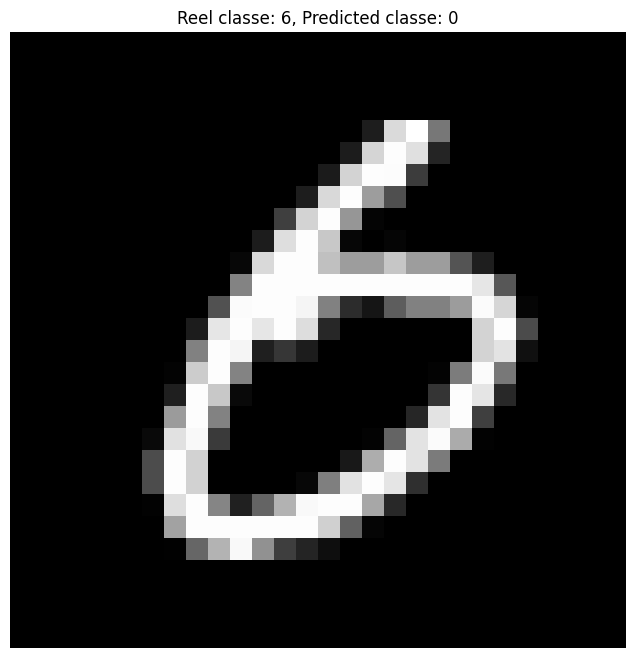

Misclassified samples 5:
Reel classe: 2, Predicted classe: 7


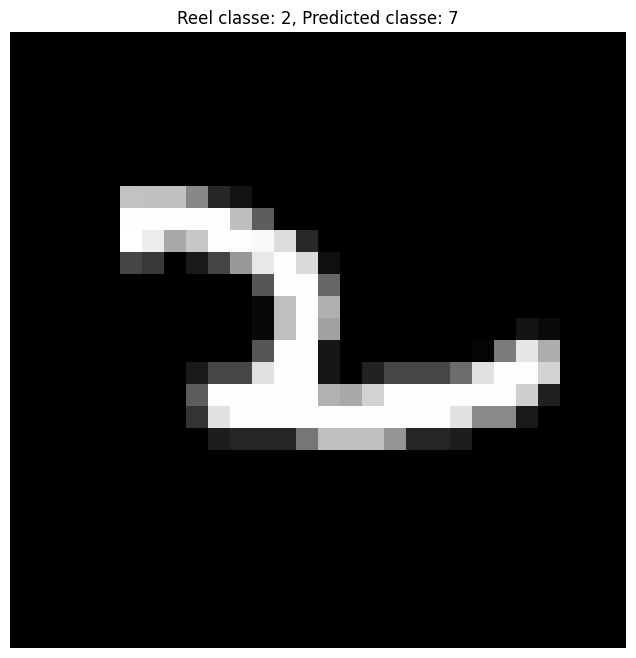

Misclassified samples 6:
Reel classe: 5, Predicted classe: 3


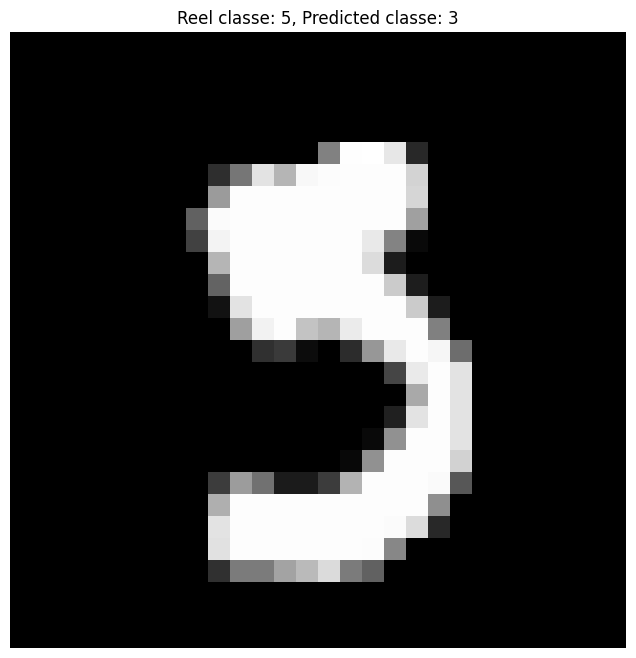

Misclassified samples 7:
Reel classe: 9, Predicted classe: 7


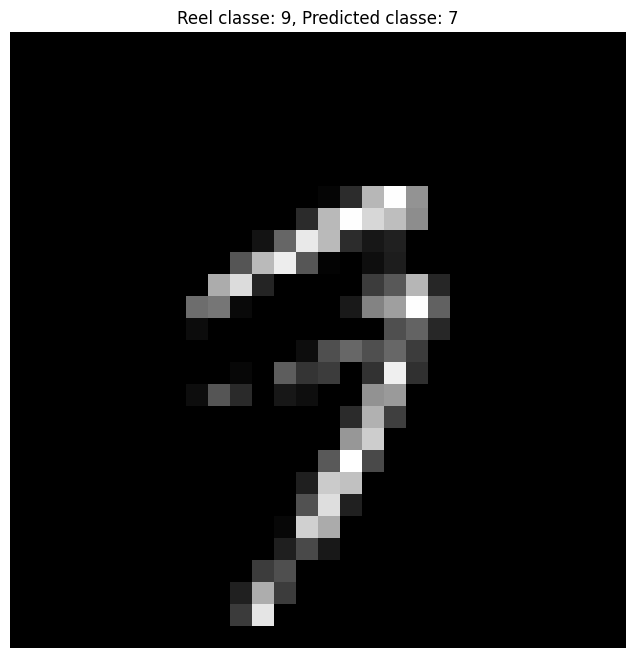

Misclassified samples 8:
Reel classe: 2, Predicted classe: 0


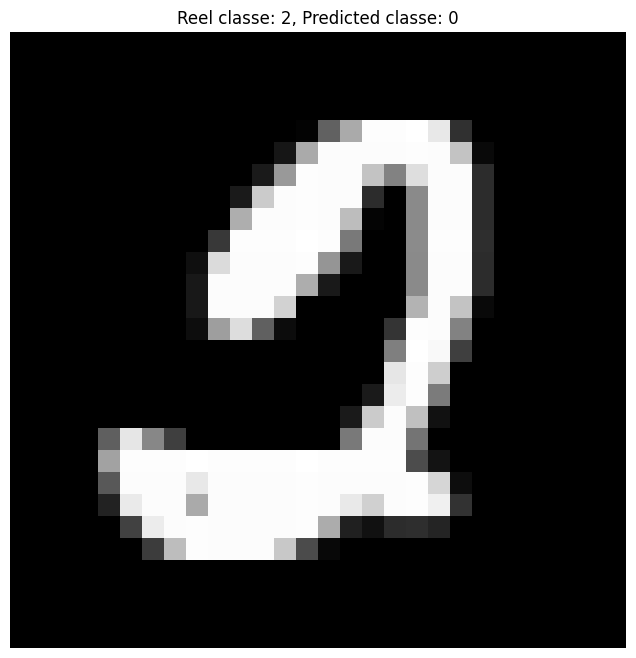

Misclassified samples 9:
Reel classe: 8, Predicted classe: 2


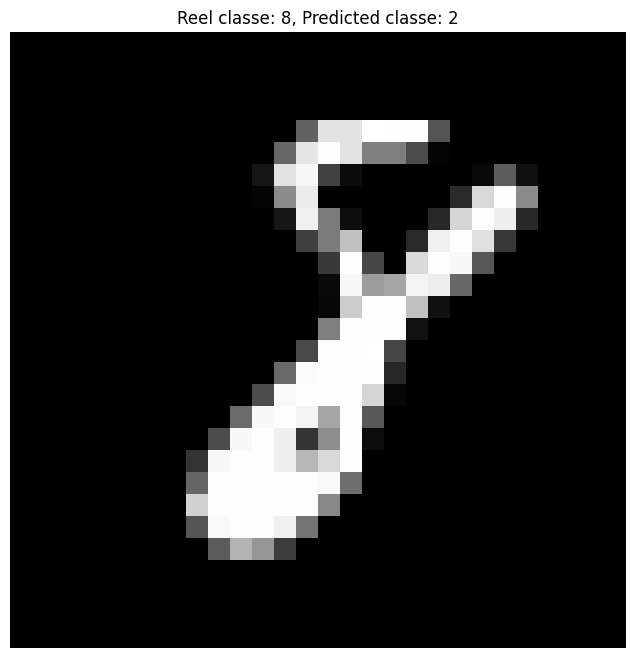

Misclassified samples 10:
Reel classe: 4, Predicted classe: 6


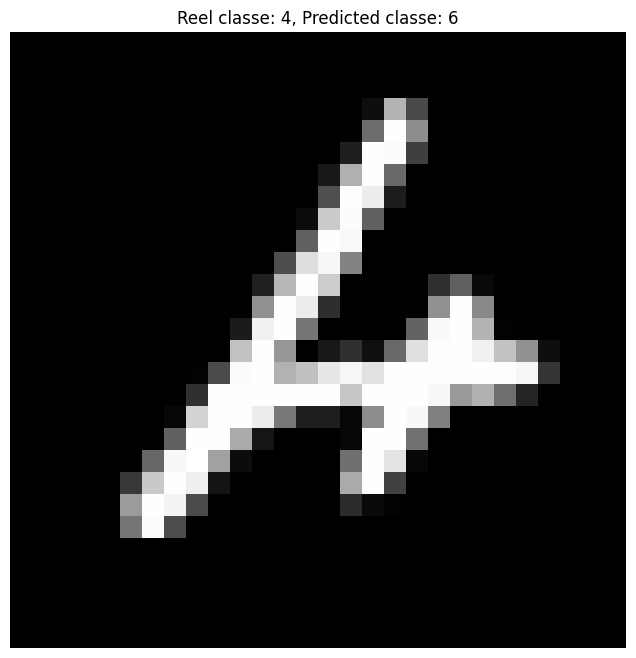

Misclassified samples 11:
Reel classe: 0, Predicted classe: 7


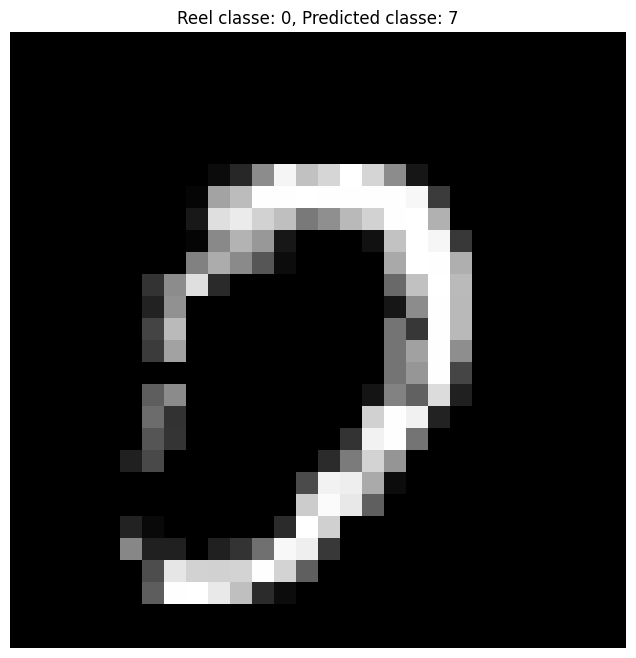

Misclassified samples 12:
Reel classe: 9, Predicted classe: 8


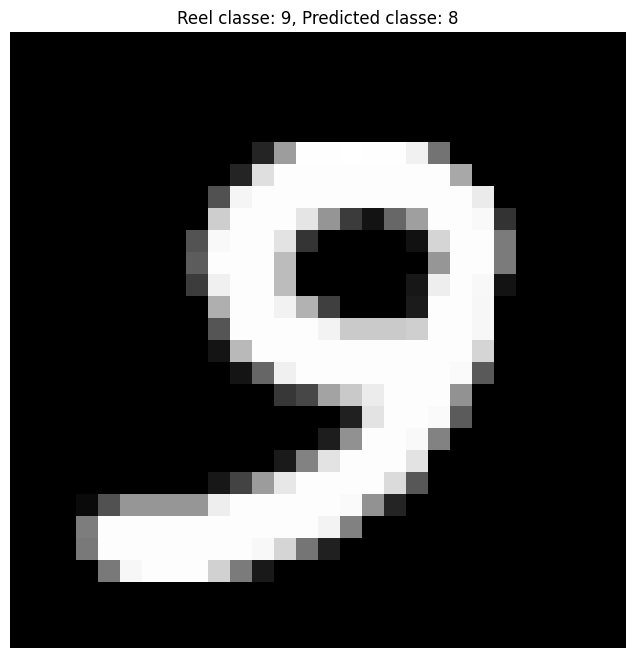

Misclassified samples 13:
Reel classe: 9, Predicted classe: 3


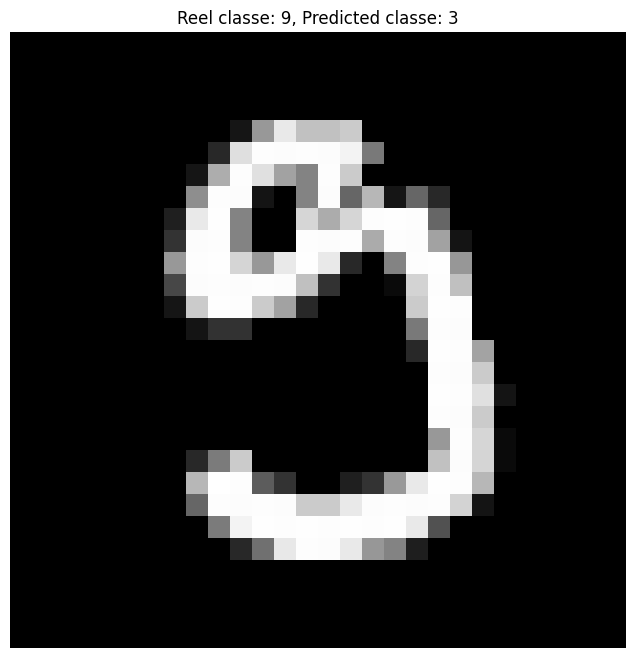

Misclassified samples 14:
Reel classe: 8, Predicted classe: 2


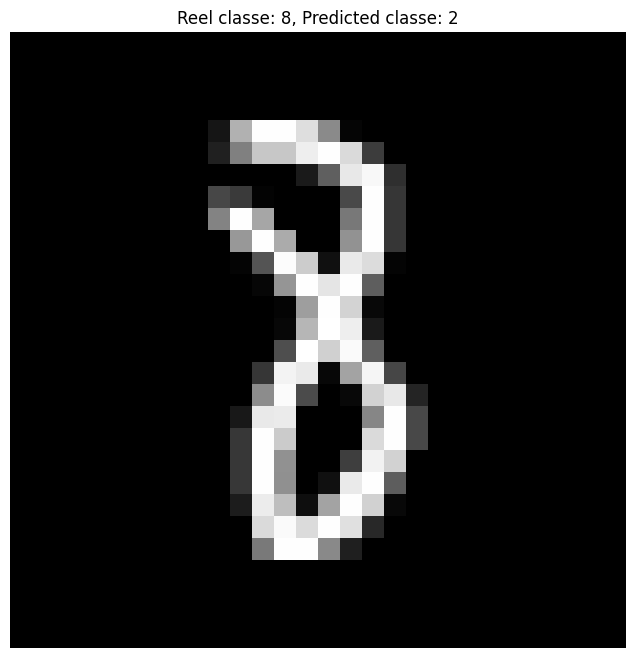

Misclassified samples 15:
Reel classe: 4, Predicted classe: 9


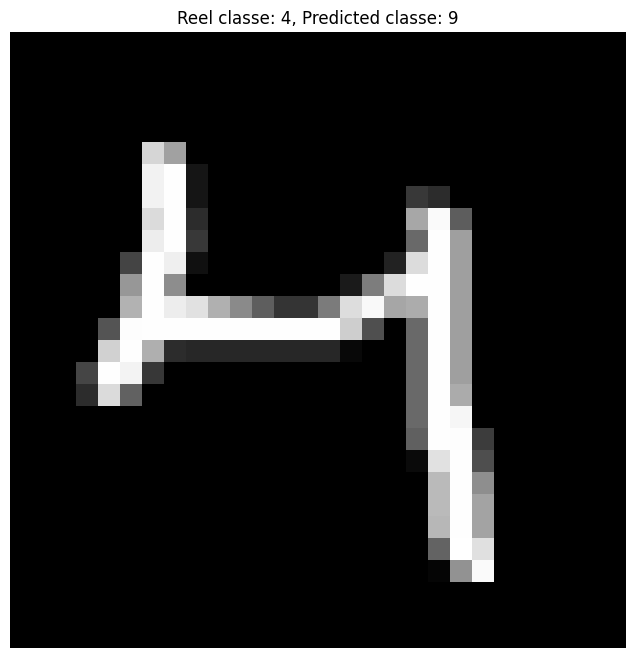

Misclassified samples 16:
Reel classe: 8, Predicted classe: 9


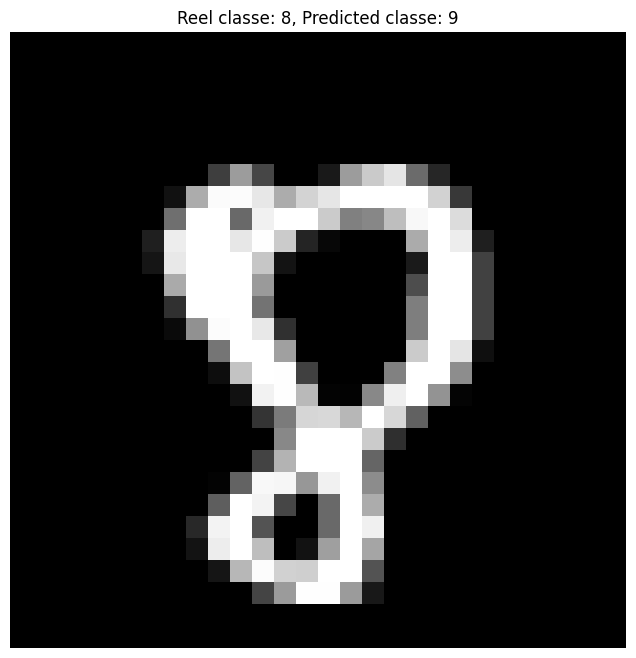

Misclassified samples 17:
Reel classe: 1, Predicted classe: 6


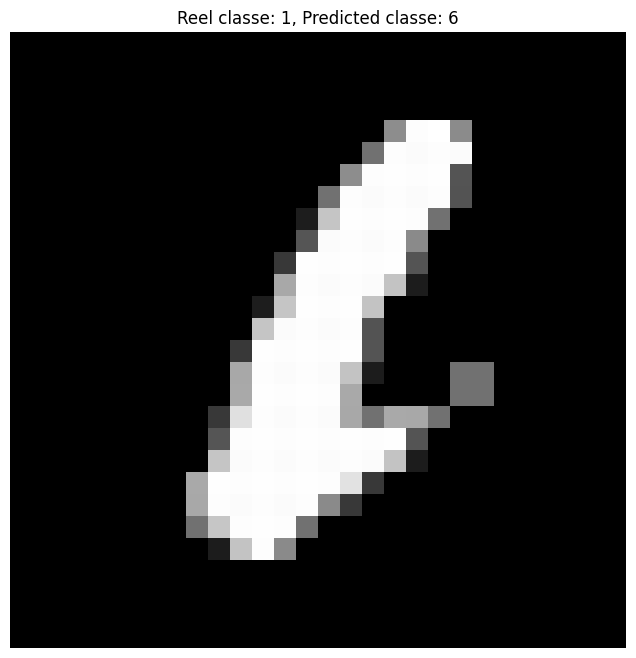

Misclassified samples 18:
Reel classe: 6, Predicted classe: 2


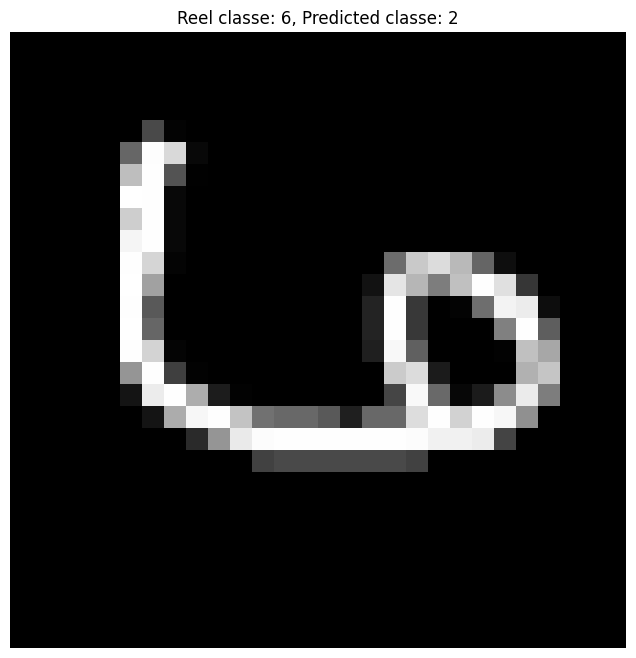

Misclassified samples 19:
Reel classe: 6, Predicted classe: 2


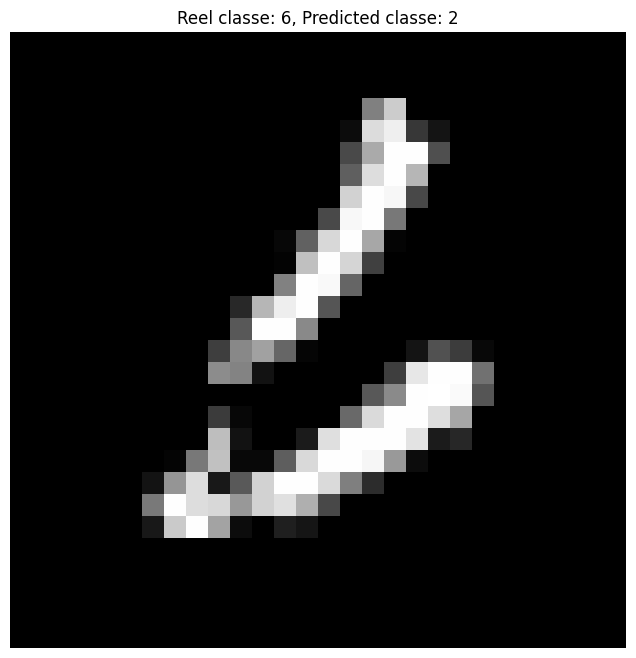

Misclassified samples 20:
Reel classe: 8, Predicted classe: 2


KeyboardInterrupt: 

In [18]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

# Function to display an image
def imshow(img, title):
    plt.figure(figsize=(8, 8))
    plt.imshow(img.reshape(28, 28), cmap='gray')  # Resize the image to match the initial size of the MNIST image
    plt.title(title)
    plt.axis('off')
    plt.show()

# Function to get misclassified samples
def get_misclassified_samples(dataloader, model):
    misclassified_samples = []
    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            predicted = torch.argmax(outputs, dim=1)
            misclassified_mask = predicted != labels
            misclassified_images = images[misclassified_mask]
            misclassified_labels = labels[misclassified_mask]
            predicted_labels = predicted[misclassified_mask]
            misclassified_samples.extend([(image, true_label, predicted_label) for image, true_label, predicted_label in zip(misclassified_images, misclassified_labels, predicted_labels)])
    return misclassified_samples

# Obtain misclassified samples
misclassified_samples = get_misclassified_samples(test_dataloader, model)

# Display misclassified samples
for i, (image, true_label, predicted_label) in enumerate(misclassified_samples):
    print(f"Misclassified samples {i+1}:")
    print(f"Reel classe: {true_label}, Predicted classe: {predicted_label}")
    imshow(image, title=f"Reel classe: {true_label}, Predicted classe: {predicted_label}")
